### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH, FOREX_DATA_PATH_1HR, FOREX_DATA_PATH_15MIN, FOREX_DATA_PATH_5MIN
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
import fx_rl
from datetime import datetime, timedelta
import pytz

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

## Latest Data

In [2]:
now = datetime.now()
current_time = pd.to_datetime(now) + timedelta(hours=7)
current_time = current_time.replace(tzinfo=pytz.UTC)
# date_15min = fx_rl.bars_back(current_time, 'M15')
# date_5min = fx_rl.bars_back(current_time, 'M5')
date_1hr = fx_rl.bars_back(current_time, 'H1', total_bars=50_000)


In [3]:
sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=False,
)
sim.download_data(
    symbols=['EURUSD', 'AUDCHF', 'NZDCHF', 'GBPNZD', 'USDCAD'],
    time_range=(
        date_1hr,
        current_time
    ),
    timeframe=Timeframe.H1
)
sim.save_symbols(FOREX_DATA_PATH)
# sim.save_symbols(f'symbols_forex_15min_{date_1hr.date()}_{current_time.date()}.pkl')

In [4]:
# with open(f'symbols_forex_5min_2023-01-09_2024-05-08', 'rb') as f:
#     symbols_5min = pickle.load(f)
# # convert symbols_5min to a pd.dataframe
# symbols_5min[1]['EURUSD'].index = pd.to_datetime(symbols_5min[1]['EURUSD'].index)
# max_date_5min = symbols_5min[1]['EURUSD'].index.max()

In [5]:
# with open(f'symbols_forex_15min_2020-05-11_2024-05-08', 'rb') as f:
#     symbols_15min = pickle.load(f)
# # convert symbols_15min to a pd.dataframe
# symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)
# max_date_15min = symbols_15min[1]['EURUSD'].index.max()

In [6]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [7]:
# # unpack the pickle file and load the data that is in symbols_forex.pkl
# with open(FOREX_DATA_PATH, 'rb') as f:
#     symbols = pickle.load(f)
# # convert symbols to a pd.dataframe
# # symbols[1]['EURUSD']

In [8]:
# slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=True)
# slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=True)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [9]:
# class MyMtEnv(gym_mtsim.MtEnv):
#     # _get_modified_volume = fx_rl.my_get_modified_volume
#     _get_prices = fx_rl.my_get_prices

In [10]:
sim_train_1hr = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH_1HR
)

env_train_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_train_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [11]:
# sim_train_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_train_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [12]:
# sim_train_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_train_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [13]:
sim_validation_1hr = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_validation_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
# sim_validation_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_validation_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [15]:
# sim_validation_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_validation_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [16]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MyMtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[2],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

### Define Functions

In [17]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)

        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [18]:
space = {
    # 'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'learning_rate': hp.uniform('learning_rate', 0, 0.04), # Learning rate
    'gamma': hp.uniform('gamma', 0.925, 0.975), # Discount factor
    # 'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    'ent_coef': hp.uniform('ent_coef', 0, 0.05), # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
    # 'timeframe': hp.choice('timeframe', ['5min', '15min', '1hr'])
}

In [30]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print(f'There were not any orders produced by the model. Error: {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        # avg_reward = np.mean(reward_over_validations)
        # avg_orders = np.mean(orders_over_validations)
        # avg_profit = np.mean(profit_over_validations)
        # print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    if np.mean(profit_over_validations) > 0:
        model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

In [24]:
import os
# create a folder with the name of the date
os.makedirs(f'models_{max_date_1hr.date()}', exist_ok=True)

## Objective Function

In [27]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
step_key = 0
timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 100 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#
    global step_key

    # timeframe = params['timeframe']
    # if timeframe == '5min':
    #     env_train = env_train_5min
    #     env_validation = env_validation_5min
    # elif timeframe == '15min':
    #     env_train = env_train_15min
    #     env_validation = env_validation_15min
    # elif timeframe == '1hr':
    #     env_train = env_train_1hr
    #     env_validation = env_validation_1hr

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key += 1
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    # plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train_1hr, env_validation_1hr, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        if 'Tensor of shape' in str(e):
            print(f'''there was an error with the tensor with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        else:
            print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
                ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(profits, 'Profits')
    print_stats(orders, 'Orders')
    # label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    # plot_data[plot_key] = rewards
    # plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['rewards'] = np.mean(rewards)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [21]:
# # # check if it is working:
# parameters = {
#     # 'window_size': 10,
#     # 'learning_timesteps': 25,
#     'ent_coef': 0.008841807731982131,
#     # 'gamma': 0.9484679718228304,
#     'learning_rate': 0.021173768344759137
# }
# objective(parameters)

In [22]:

# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [31]:
#### adding in gamma test ####
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250, # Number of evaluations of the objective function
            trials=trials,
            trials_save_file=f'gym_mtsim_forked/examples/hyperopt/trials_5_24_search_next_week.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
entropy: 0.009330845963932539, learning rate: 0.010049657065901978, gamma: 0.9259766647601245
Min. Profits          :   -918.072                     
Avg. Profits          :   -197.384                     
Max. Profits          :    363.301                     
Min. Orders          :     28.000                      
Avg. Orders          :     36.500                      
Max. Orders          :     43.000                      
--------------------------------------------------------------------------------     
entropy: 0.02909647565994384, learning rate: 0.00660410300543913, gamma: 0.9647233807901131
Min. Profits          :   -955.510                                                   
Avg. Profits          :   -214.888                                                   
Max. Profits          :    348.977                                                   
Min. Orders          :     44.000                    

In [ ]:
# # make a sound when the code is done
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)

# Testing Hyperparameters

In [32]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_24_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': 197.38392438361532, 'status': 'ok', 'eval_time': 1716590340.3401678, 'parameters': {'ent_coef': 0.009330845963932539, 'gamma': 0.9259766647601245, 'learning_rate': 0.010049657065901978, 'avg_orders': 36.5, 'rewards': -0.1395606217513547}}


In [33]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,197.383924,ok,0.010050,0.009331,0.925977,36.5,-0.139561
1,214.888272,ok,0.006604,0.029096,0.964723,47.7,-0.124552
2,232.395790,ok,0.026785,0.023000,0.943740,52.0,-0.143686
3,172.226578,ok,0.031740,0.026340,0.952455,49.1,-0.093311
4,333.387258,ok,0.006724,0.024710,0.932756,82.6,-0.099585
...,...,...,...,...,...,...,...
245,-43.967642,ok,0.008293,0.017155,0.967180,41.2,0.073432
246,39.556875,ok,0.001615,0.031528,0.958985,3.2,-0.742916
247,91.667211,ok,0.007330,0.001584,0.957747,51.0,-0.027681
248,-1.061648,ok,0.002375,0.010648,0.933947,0.1,-0.100000


In [34]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
69,-857.307771,ok,0.005534,0.000018,0.961909,43.9,0.675225
160,-686.923306,ok,0.008660,0.009552,0.957712,26.6,0.920290
176,-650.439025,ok,0.005061,0.005251,0.974864,17.7,1.377346
9,-538.356140,ok,0.002363,0.000431,0.951720,44.9,0.436050
215,-391.870526,ok,0.007979,0.000004,0.939436,23.6,0.633337
177,-388.726212,ok,0.013199,0.004537,0.973556,34.4,0.429332
66,-338.225200,ok,0.000851,0.007731,0.964957,35.2,0.451745
223,-310.667654,ok,0.012324,0.001218,0.953061,12.6,1.315126
85,-284.405949,ok,0.000996,0.008102,0.953248,16.0,1.626103
203,-277.232087,ok,0.001859,0.001860,0.969933,21.3,0.629323


In [35]:
total_learning_timesteps = 250 * 1_000

In [36]:
custom_palette = sns.color_palette(["red", "green"])

In [37]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [38]:
# find all of the models that are in the /models_2024_05_17 folder
folder_path = f'C:/Users/WilliamFetzner/Documents/Trading/models_{max_date_1hr.date()}'

# Get the list of files in the folder
file_list = os.listdir(folder_path)
file_list[0]

'model_107_2024-05-24.pkl'

In [43]:
file_list

['model_107_2024-05-24.pkl',
 'model_135_2024-05-24.pkl',
 'model_148_2024-05-24.pkl',
 'model_154_2024-05-24.pkl',
 'model_155_2024-05-24.pkl',
 'model_15_2024-05-24.pkl',
 'model_164_2024-05-24.pkl',
 'model_166_2024-05-24.pkl',
 'model_167_2024-05-24.pkl',
 'model_172_2024-05-24.pkl',
 'model_175_2024-05-24.pkl',
 'model_178_2024-05-24.pkl',
 'model_182_2024-05-24.pkl',
 'model_183_2024-05-24.pkl',
 'model_205_2024-05-24.pkl',
 'model_209_2024-05-24.pkl',
 'model_213_2024-05-24.pkl',
 'model_221_2024-05-24.pkl',
 'model_226_2024-05-24.pkl',
 'model_229_2024-05-24.pkl',
 'model_251_2024-05-24.pkl',
 'model_254_2024-05-24.pkl',
 'model_38_2024-05-24.pkl',
 'model_72_2024-05-24.pkl',
 'model_75_2024-05-24.pkl',
 'model_77_2024-05-24.pkl',
 'model_83_2024-05-24.pkl',
 'model_87_2024-05-24.pkl',
 'model_90_2024-05-24.pkl',
 'model_91_2024-05-24.pkl',
 'model_97_2024-05-24.pkl']

In [39]:
# get the model number from the file name when the file name has the format 'model_##_2024-05-17.pkl' where the ## is the model number
model_nums = [x.split('_')[1] for x in file_list]

In [40]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
num_episodes = 1_000

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()

train_env, env_validation_2 = env_fx(slices_1hr)
obs_test, info_test = env_validation_2.reset(seed=seed)
obs_tr, info_tr = train_env.reset(seed=seed)

for num, model in tqdm(zip(model_nums, file_list)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0
    print_stats(rewards, 'Profits')
    reward_over_tests[f'model_{num}'] = rewards
# print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


1it [01:32, 92.12s/it]

Min. Profits          :  -1236.571
Avg. Profits          :    213.343
Max. Profits          :   2978.341
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

2it [02:39, 77.65s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -222.244
Avg. Profits          :     -1.774
Max. Profits          :    211.693


3it [04:28, 91.77s/it]

Min. Profits          :  -1363.014
Avg. Profits          :    112.703
Max. Profits          :   1502.260
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

4it [05:45, 85.88s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -343.678
Avg. Profits          :     19.317
Max. Profits          :    890.854
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

5it [06:53, 79.46s/it]

Min. Profits          :   -216.014
Avg. Profits          :     -2.884
Max. Profits          :    305.567


6it [08:42, 89.51s/it]

Min. Profits          :   -676.892
Avg. Profits          :    525.033
Max. Profits          :   1410.082
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

7it [09:53, 83.68s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -197.760
Avg. Profits          :     -0.616
Max. Profits          :    271.047


8it [11:44, 92.33s/it]

Min. Profits          :   -481.288
Avg. Profits          :    851.713
Max. Profits          :   2334.919
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

9it [12:56, 85.81s/it]

Min. Profits          :   -223.479
Avg. Profits          :      2.226
Max. Profits          :    480.067
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

10it [14:05, 80.73s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -147.257
Avg. Profits          :      6.539
Max. Profits          :    429.874


11it [15:40, 85.12s/it]

Min. Profits          :  -1045.902
Avg. Profits          :     53.378
Max. Profits          :   1244.031


12it [16:58, 82.85s/it]

Min. Profits          :   -737.820
Avg. Profits          :    -73.147
Max. Profits          :    565.844


13it [18:38, 88.01s/it]

Min. Profits          :   -595.455
Avg. Profits          :    532.228
Max. Profits          :   1770.240


14it [20:20, 92.31s/it]

Min. Profits          :   -820.425
Avg. Profits          :    358.637
Max. Profits          :   1738.000
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

15it [21:29, 85.47s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -226.856
Avg. Profits          :     -2.514
Max. Profits          :    227.467


16it [23:04, 88.26s/it]

Min. Profits          :   -602.600
Avg. Profits          :    228.786
Max. Profits          :   1414.497
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

17it [24:14, 82.63s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -114.071
Avg. Profits          :     -2.847
Max. Profits          :    152.170


18it [25:49, 86.51s/it]

Min. Profits          :   -884.756
Avg. Profits          :    311.948
Max. Profits          :   1467.245
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

19it [26:59, 81.52s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -252.677
Avg. Profits          :     -1.711
Max. Profits          :    441.575


20it [28:31, 84.70s/it]

Min. Profits          :   -718.388
Avg. Profits          :    276.660
Max. Profits          :   1540.354


21it [30:10, 88.98s/it]

Min. Profits          :  -1027.587
Avg. Profits          :     89.870
Max. Profits          :   1182.826
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

22it [31:19, 82.99s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -293.162
Avg. Profits          :     -2.514
Max. Profits          :    169.517
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

23it [32:28, 78.73s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -131.224
Avg. Profits          :     -1.272
Max. Profits          :    337.458


24it [34:09, 85.49s/it]

Min. Profits          :  -1400.439
Avg. Profits          :    251.374
Max. Profits          :   1809.558


25it [36:03, 93.91s/it]

Min. Profits          :     70.459
Avg. Profits          :    719.874
Max. Profits          :   1399.689
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

26it [37:13, 86.70s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -190.097
Avg. Profits          :     -1.787
Max. Profits          :    269.585


27it [38:51, 90.01s/it]

Min. Profits          :  -1031.405
Avg. Profits          :    113.254
Max. Profits          :   1503.516


28it [40:28, 92.17s/it]

Min. Profits          :  -1185.295
Avg. Profits          :    183.178
Max. Profits          :   1691.233
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

29it [41:37, 85.36s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -262.831
Avg. Profits          :     -4.167
Max. Profits          :    258.442


30it [43:09, 87.29s/it]

Min. Profits          :  -1076.525
Avg. Profits          :    161.762
Max. Profits          :   1900.593
There were not any orders produced by the model. Error = 'Volume'


31it [44:35, 86.30s/it]

Min. Profits          :   -885.037
Avg. Profits          :     -5.513
Max. Profits          :   1496.049


In [41]:
df = pd.DataFrame(reward_over_tests)
# replace any 0s in the dataframe with nans
df_nan_replaced = df.replace(0, np.nan)
df_nan_replaced

,model_107,model_135,model_148,model_154,model_155,model_15,model_164,model_166,model_167,model_172,...,model_254,model_38,model_72,model_75,model_77,model_83,model_87,model_90,model_91,model_97
0,263.016526,NaN,-92.409757,138.227427,NaN,491.645544,NaN,806.716507,145.223526,NaN,...,NaN,-106.329913,686.442236,1113.533584,-1.943480,23.775466,361.099468,NaN,-57.020615,164.432996
1,1044.542156,NaN,384.903317,NaN,-37.128164,318.280907,4.923315,771.933957,-120.430311,NaN,...,NaN,-9.854084,159.233618,752.617203,NaN,866.131064,730.475858,2.342948,46.627918,-8.074386
2,-150.855705,1.116004,93.666594,-107.546200,-21.042226,953.588464,NaN,956.673540,NaN,NaN,...,NaN,NaN,387.663275,712.061957,NaN,642.149405,-94.902774,NaN,-140.854192,9.477999
3,1676.193810,49.027654,-592.364623,-113.029574,NaN,600.159717,NaN,855.957921,NaN,NaN,...,NaN,NaN,1149.590942,477.375684,-36.945319,-138.282835,93.686530,NaN,346.867472,70.180492
4,482.561627,NaN,419.376362,-238.145776,NaN,318.593073,-57.535902,395.711110,130.570187,NaN,...,NaN,NaN,51.664387,402.508398,71.350358,748.982601,322.626175,23.086809,-535.225344,-143.827329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1072.229029,NaN,543.339542,162.499988,NaN,683.547044,NaN,1054.625282,NaN,NaN,...,NaN,NaN,599.374258,723.983117,-47.888650,675.578385,-153.804062,NaN,-186.615892,-405.332348
996,-202.629644,-7.025263,-850.827825,216.270107,NaN,1166.483606,NaN,1081.811697,NaN,NaN,...,NaN,-3.883399,60.039399,635.002642,NaN,57.441012,7.239796,NaN,362.158087,358.790372
997,-338.585129,NaN,-256.768574,NaN,NaN,409.468478,14.632397,316.861475,NaN,NaN,...,NaN,NaN,1002.912523,506.166815,NaN,278.233316,178.366933,NaN,120.256564,168.093694
998,534.485544,NaN,962.690767,201.531710,NaN,830.660690,8.939150,1608.574771,-70.197435,NaN,...,NaN,-15.642036,108.650713,962.509098,19.639343,-293.688731,-244.034053,NaN,156.383850,-199.223671


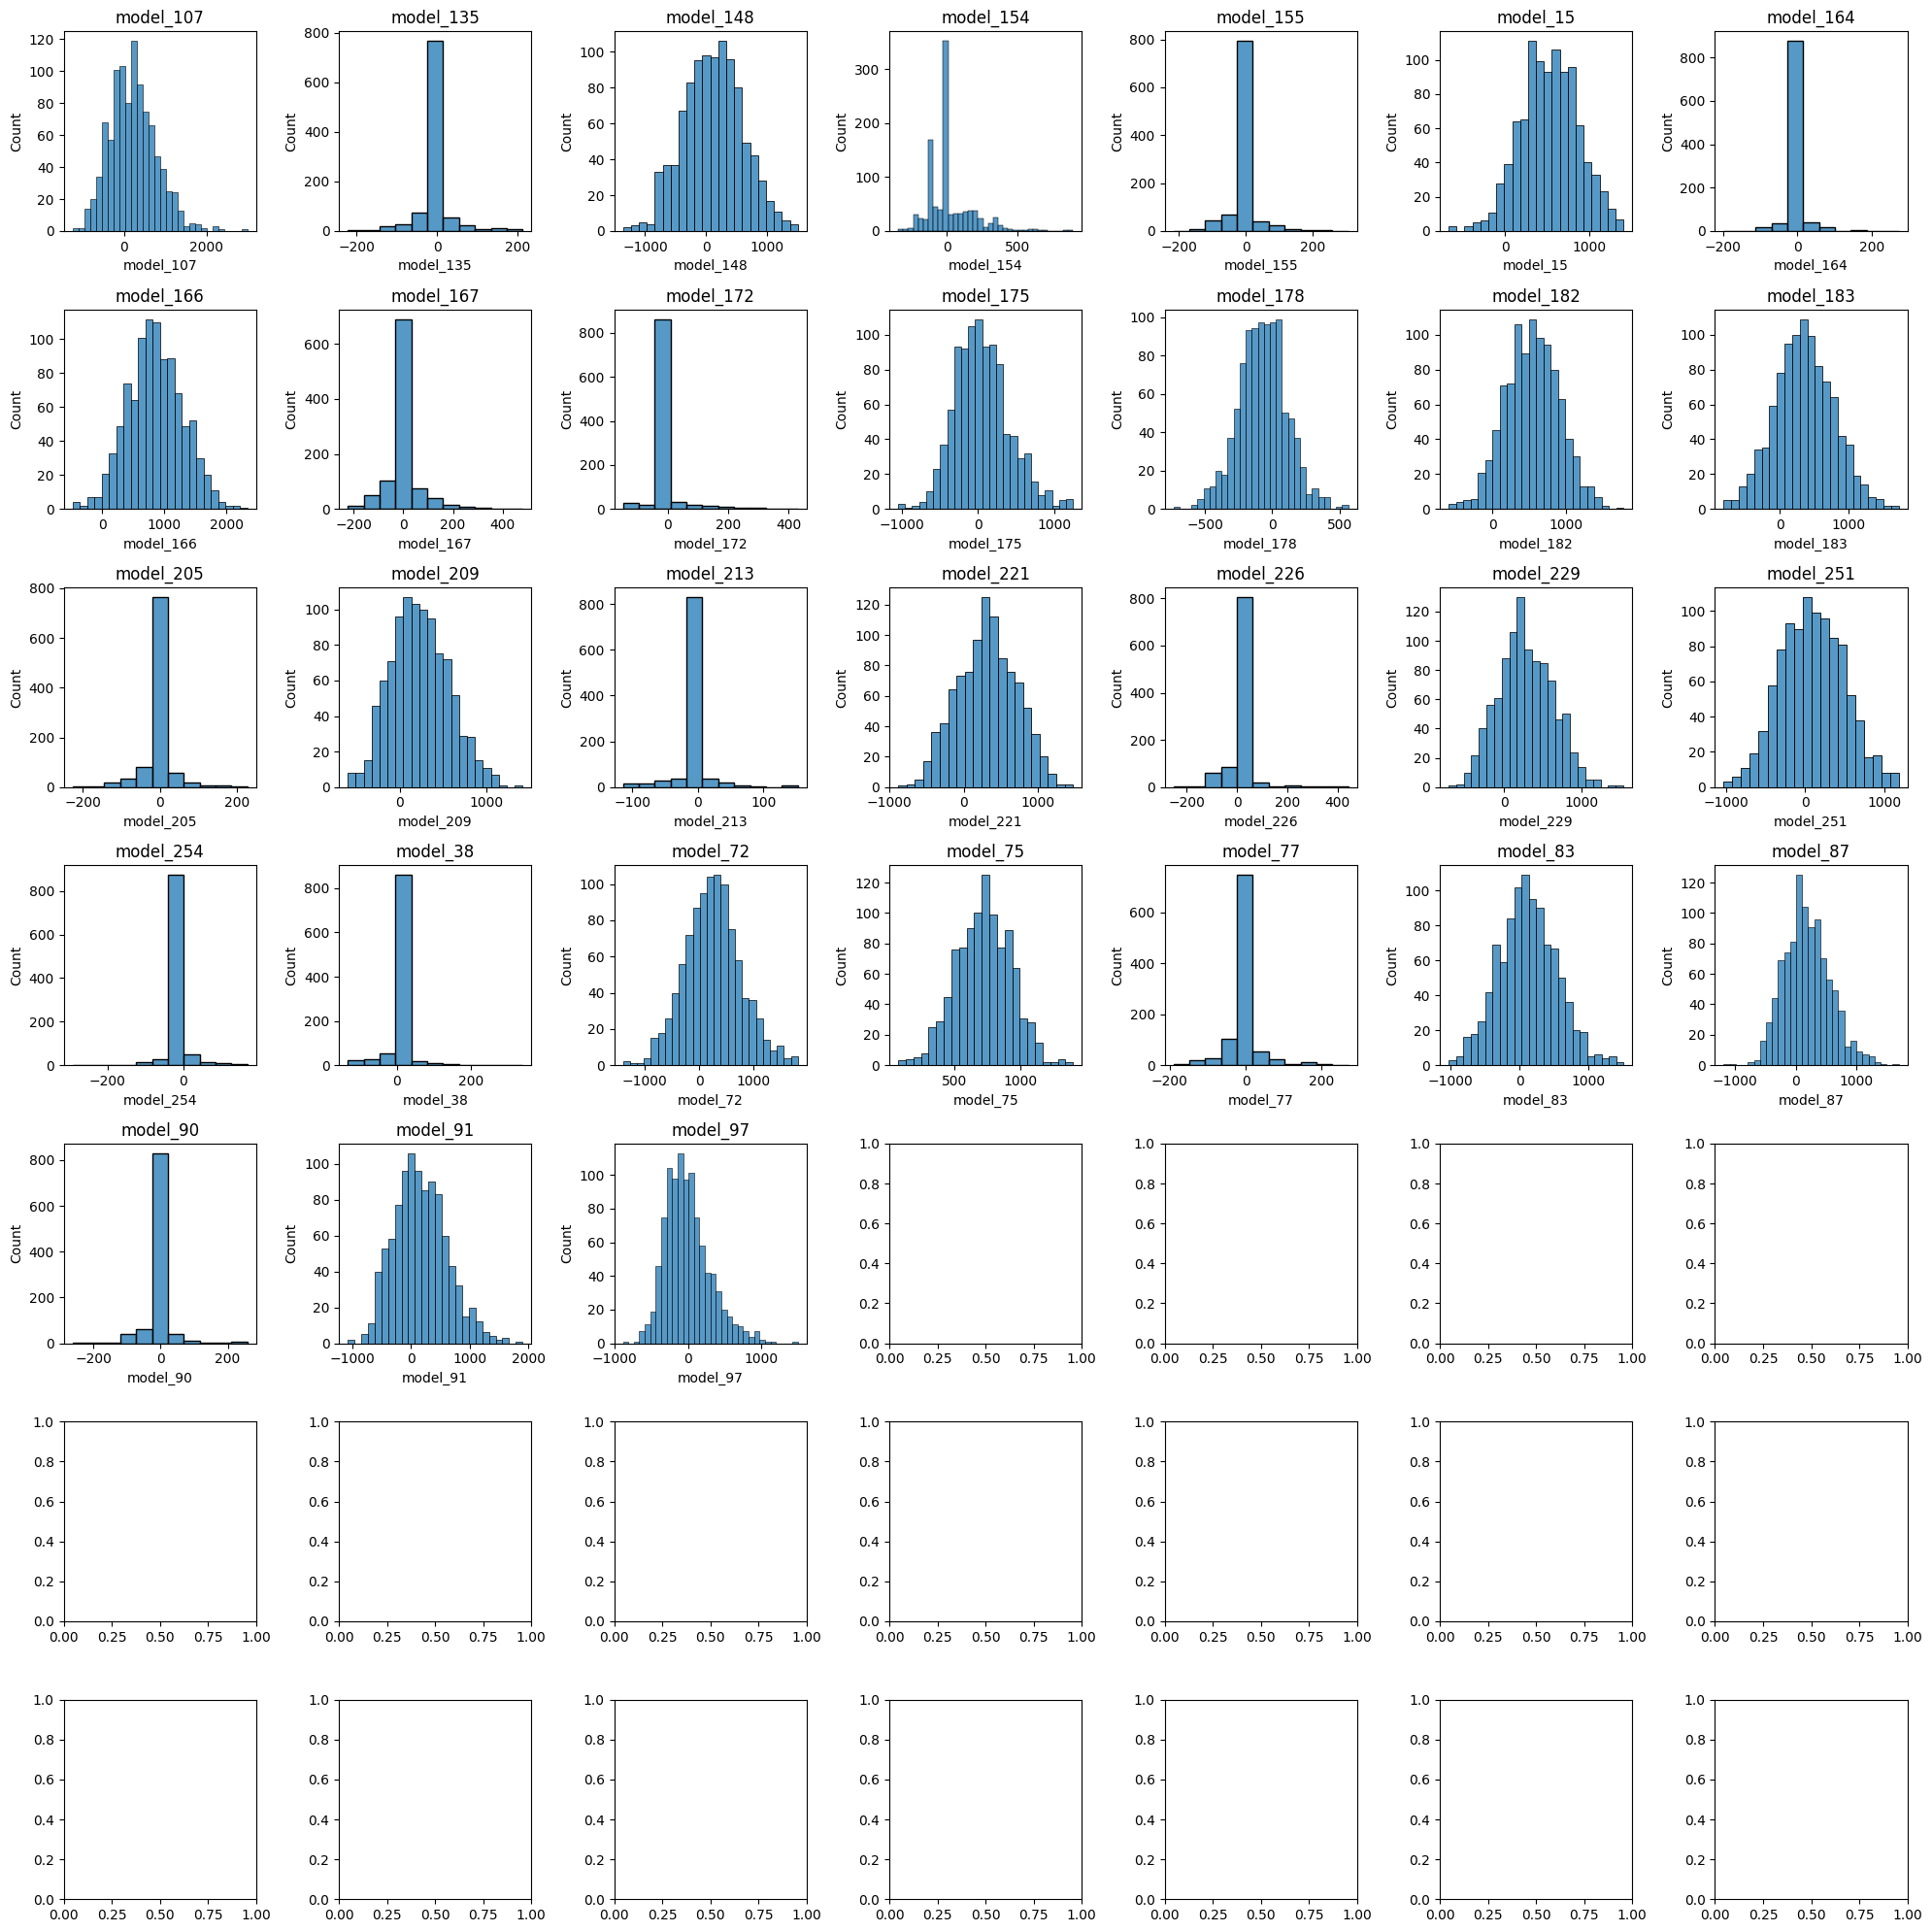

In [42]:
# Create a grid of subplots for every column in df where there are 7 rows and 7 columns that show the distribution of the data

# Create a grid of subplots
fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(20, 20))

# Flatten the axs array
axs = axs.flatten()

# Iterate over the columns in df
for i, col in enumerate(df.columns):
    # Plot the distribution of the column
    sns.histplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()